In [43]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import tensorflow.keras as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Conv2D, Dropout
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import csv
import random

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [44]:
def retrieve_data(varname, filename):
    if "combined" in filename:
        df = pd.read_csv(filename)
    else:
        df = pd.read_csv(filename, index_col=0)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

def create_classification_data(df, lookback, column):
    rows = []
    columns = ['Date', column] # Date and SP500_relative_change_perc_1 from t-0 are added first as target variables 
    # create column names based on original with the addition of t-i where i is lookback
    for i in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
        new_columns = df.columns.tolist() # starts at 1 to exclude 'Date' column
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
    
    # create lookback data
    for i, row in enumerate(df.iterrows()):
        if i > lookback: # lookback cannot be determined for earlier rows
            new_row = [row[1]['Date'], row[1][column]]
#             new_row = [row[1][0], row[1][1]] # add target 'Date' and 'SP500_relative_change_perc_1 '
            for x in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
                add_row = df.iloc[i - x].tolist() # starts at 1 to exclude 'Date' column
                new_row = new_row + add_row
            rows.append(new_row)
    
    df2 = pd.DataFrame(rows)
    df2.columns = columns
                       
    for col in columns:
        if col[:4] == "Date" and col != "Date":
            df2 = df2.drop([col], axis=1)
    return df2

def create_train_val_test(df, year_val, year_test, perc_train=None):
    if perc_train == None:
        # assumes years_train < year_val < year_test
        df["Date"] = pd.to_datetime(df["Date"])
        
        val = df[df['Date'].dt.year == year_val]
        test = df[df['Date'].dt.year == year_test]
        train = df[df['Date'].dt.year < year_val]
    else:
        train = df.head(round(len(df) * perc_train))
        val = df.tail(len(df) - len(train))
        test = val.tail(round(0.5 * len(val)))
        val = val.head(len(val) - len(test))
    y_train = train['SP500_relative_change_perc_1']
    x_train = train.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_val = val['SP500_relative_change_perc_1']
    x_val = val.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_test = test['SP500_relative_change_perc_1']
    x_test = test.drop(['SP500_relative_change_perc_1'], axis=1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def scale_data(x):
    standard_scaler = MinMaxScaler()
    x_scaled = pd.DataFrame(standard_scaler.fit_transform(x), columns=x.columns)
    return x_scaled

In [45]:
val_year = 2018
test_year = 2019


mode = 'reduced'
if mode == 'reduced':
    files = {
        # varname: filename
        "S&P500": "Dataset v3/SP500_reduced_data_20220425.csv",
    #     "S&P500": "Dataset v3/SP500_combined_data_20220422.csv"
    }
else:
    files = {
        # varname: filename
        "S&P500": "Dataset v3/SP500_combined_data_20220422.csv",
    #     "S&P500": "Dataset v3/SP500_combined_data_20220422.csv"
    }

for file in files:
    df = retrieve_data(file, files[file])
    
lookback = 10
if mode == 'reduced': # REDUCED DATA
    if lookback == 3:
        features = ['SP500_stochastic_D_5_5_t-3', 'SP500_momentum_16_t-1', 'SP500_williams_R_10_t-1', 'SP500_williams_R_20_t-1', 'SP500_AD_MACD_12_26_t-3', 'SP500_stochastic_D_5_5_t-1', 'SP500_stochastic_K_50_t-3', 'SP500_F_relative_change_perc_1_t-3', 'SP500_stochastic_K_5_t-3', 'SP500_williams_R_5_t-1', 'Gold_F_relative_change_perc_1_t-2', 'SP500_stochastic_K_10_t-1', 'SP500_AD_oscillator_t-1', 'SP500_williams_R_10_t-2', 'SP500_momentum_8_t-1', 'SP500_stochastic_D_5_5_t-2']
    elif lookback == 5:
        features = ['SP500_momentum_16_t-1', 'SP500_williams_R_5_t-5', 'SP500_stochastic_K_50_t-5', 'SP500_williams_R_20_t-1', 'SP500_relative_change_perc_1_t-4', 'SP500_williams_R_50_t-3', 'SP500_AD_oscillator_t-4', 'SP500_stochastic_K_5_t-4', 'SP500_F_relative_change_perc_1_t-3', 'SP500_AD_oscillator_t-3', 'Silver_F_relative_change_perc_1_t-5', 'Gold_F_relative_change_perc_1_t-2', 'SP500_stochastic_K_50_t-4', 'SP500_williams_R_50_t-4', 'SP500_stochastic_K_10_t-1', 'Silver_F_relative_change_perc_1_t-4', 'SP500_AD_oscillator_t-1', 'SP500_williams_R_10_t-2', 'SP500_stochastic_K_5_t-2', 'SP500_stochastic_D_5_5_t-2', 'SP500_williams_R_20_t-3', 'Copper_F_relative_change_perc_1_t-4']
    elif lookback == 10:
        features = ['SP500_stochastic_K_50_t-5', 'SP500_williams_R_10_t-3', 'SP500_relative_change_perc_1_t-4', 'SP500_williams_R_50_t-3', 'Copper_F_relative_change_perc_1_t-7', 'SP500_stochastic_K_20_t-4', 'Gold_F_relative_change_perc_1_t-10', 'SP500_stochastic_K_5_t-4', 'SP500_momentum_16_t-7', 'SP500_stochastic_K_10_t-10', 'Silver_F_relative_change_perc_1_t-5', 'Gold_F_relative_change_perc_1_t-2', 'SP500_stochastic_K_50_t-4', 'SP500_williams_R_50_t-4', 'SP500_stochastic_K_10_t-1', 'SP500_stochastic_K_10_t-7', 'SP500_AD_oscillator_t-9', 'SP500_AD_oscillator_t-1', 'SP500_stochastic_K_5_t-2', 'Silver_F_relative_change_perc_1_t-10', 'SP500_stochastic_D_5_5_t-5', 'SP500_williams_R_10_t-7']
    elif lookback == 20:
        features = ['Silver_F_relative_change_perc_1_t-16', 'Copper_F_relative_change_perc_1_t-19', 'Gold_F_relative_change_perc_1_t-14', 'SP500_stochastic_K_50_t-13', 'Silver_F_relative_change_perc_1_t-5', 'SP500_AD_oscillator_t-6', 'SP500_F_relative_change_perc_1_t-13', 'SP500_AD_oscillator_t-17', 'Silver_F_relative_change_perc_1_t-8', 'SP500_stochastic_K_10_t-1', 'SP500_F_relative_change_perc_1_t-12', 'SP500_relative_change_perc_1_t-18', 'SP500_stochastic_K_5_t-6', 'SP500_stochastic_K_50_t-11', 'SP500_williams_R_5_t-5', 'SP500_williams_R_10_t-8', 'SP500_AD_oscillator_t-4', 'Copper_F_relative_change_perc_1_t-4', 'SP500_stochastic_K_10_t-10', 'SP500_williams_R_50_t-11', 'SP500_williams_R_50_t-4', 'SP500_momentum_8_t-20', 'SP500_momentum_8_t-4', 'SP500_stochastic_K_5_t-20', 'Silver_F_relative_change_perc_1_t-19', 'SP500_F_relative_change_perc_1_t-17', 'SP500_williams_R_5_t-18', 'SP500_F_relative_change_perc_1_t-10', 'SP500_momentum_8_t-14', 'Gold_F_relative_change_perc_1_t-10', 'SP500_stochastic_K_5_t-4', 'SP500_AD_oscillator_t-14', 'SP500_stochastic_K_50_t-4', 'Gold_F_relative_change_perc_1_t-8', 'SP500_stochastic_K_10_t-7', 'Silver_F_relative_change_perc_1_t-4', 'Silver_F_relative_change_perc_1_t-1', 'SP500_AD_oscillator_t-1', 'Copper_F_relative_change_perc_1_t-11', 'SP500_AD_oscillator_t-15', 'SP500_williams_R_10_t-11', 'SP500_stochastic_D_5_5_t-5', 'SP500_momentum_16_t-5', 'SP500_relative_change_perc_1_t-16', 'SP500_stochastic_K_50_t-5', 'SP500_stochastic_K_5_t-16', 'SP500_AD_MACD_12_26_t-8', 'SP500_momentum_16_t-7', 'Copper_F_relative_change_perc_1_t-6', 'SP500_stochastic_D_5_5_t-19', 'SP500_AD_oscillator_t-20', 'SP500_relative_change_perc_1_t-2', 'SP500_williams_R_50_t-14', 'SP500_stochastic_K_50_t-14', 'SP500_momentum_16_t-14', 'SP500_momentum_16_t-20', 'Gold_F_relative_change_perc_1_t-13', 'SP500_williams_R_5_t-6']
else: # COMBINED DATA
    if lookback == 3:
        features = ['SP500_momentum_8_t-1', 'SP500_momentum_16_t-1', 'SP500_stochastic_K_10_t-1', 'SP500_AD_MACD_12_26_t-3', 'SP500_stochastic_K_50_t-3', 'Gold_F_relative_change_perc_1_t-2', 'SP500_williams_R_5_t-1', 'SP500_williams_R_10_t-2', 'SP500_stochastic_D_5_5_t-2', 'SP500_williams_R_20_t-1', 'SP500_relative_change_perc_1_t-3', 'SP500_williams_R_10_t-1', 'SP500_stochastic_D_5_5_t-1', 'SP500_AD_oscillator_t-1', 'SP500_stochastic_D_5_5_t-3', 'SP500_stochastic_K_5_t-3']
    elif lookback == 5:
        features = ['Silver_F_relative_change_perc_1_t-5', 'SP500_momentum_16_t-1', 'Silver_F_relative_change_perc_1_t-4', 'SP500_stochastic_K_5_t-2', 'SP500_stochastic_K_10_t-1', 'SP500_stochastic_K_5_t-4', 'Copper_F_relative_change_perc_1_t-4', 'SP500_williams_R_50_t-4', 'SP500_AD_oscillator_t-4', 'SP500_williams_R_50_t-3', 'SP500_AD_oscillator_t-3', 'SP500_stochastic_K_50_t-4', 'SP500_stochastic_K_50_t-5', 'SP500_relative_change_perc_1_t-4', 'SP500_williams_R_5_t-5', 'Gold_F_relative_change_perc_1_t-2', 'SP500_stochastic_D_5_5_t-2', 'SP500_williams_R_20_t-1', 'SP500_relative_change_perc_1_t-3', 'SP500_AD_oscillator_t-1']
    elif lookback == 10:
        features = ['Silver_F_relative_change_perc_1_t-5', 'Copper_F_relative_change_perc_1_t-7', 'SP500_stochastic_K_5_t-2', 'SP500_williams_R_10_t-3', 'SP500_stochastic_K_10_t-1', 'SP500_stochastic_D_5_5_t-5', 'SP500_AD_oscillator_t-9', 'SP500_stochastic_K_5_t-4', 'SP500_williams_R_50_t-4', 'SP500_williams_R_50_t-3', 'SP500_stochastic_K_50_t-4', 'SP500_stochastic_K_10_t-7', 'SP500_stochastic_K_50_t-5', 'SP500_stochastic_K_10_t-10', 'SP500_relative_change_perc_1_t-4', 'SP500_momentum_16_t-7', 'SP500_williams_R_10_t-7', 'Gold_F_relative_change_perc_1_t-2', 'SP500_stochastic_K_20_t-4', 'SP500_AD_oscillator_t-1', 'Gold_F_relative_change_perc_1_t-10', 'Silver_F_relative_change_perc_1_t-10']
    elif lookback == 20:
        features = ['Silver_F_relative_change_perc_1_t-5', 'SP500_stochastic_K_50_t-17', 'Gold_F_relative_change_perc_1_t-13', 'SP500_stochastic_K_10_t-1', 'SP500_momentum_8_t-20', 'SP500_F_relative_change_perc_1_t-12', 'SP500_williams_R_50_t-11', 'SP500_AD_oscillator_t-6', 'SP500_stochastic_K_50_t-5', 'SP500_AD_oscillator_t-17', 'SP500_AD_oscillator_t-14', 'Silver_F_relative_change_perc_1_t-1', 'SP500_stochastic_K_10_t-10', 'SP500_williams_R_10_t-8', 'SP500_williams_R_5_t-5', 'Copper_F_relative_change_perc_1_t-11', 'SP500_AD_MACD_12_26_t-8', 'Gold_F_relative_change_perc_1_t-10', 'SP500_AD_oscillator_t-15', 'SP500_stochastic_K_50_t-14', 'SP500_stochastic_K_50_t-9', 'SP500_relative_change_perc_1_t-16', 'Silver_F_relative_change_perc_1_t-8', 'SP500_williams_R_5_t-6', 'SP500_momentum_16_t-5', 'SP500_momentum_16_t-7', 'SP500_williams_R_10_t-13', 'SP500_momentum_16_t-20', 'Silver_F_relative_change_perc_1_t-14', 'SP500_stochastic_K_10_t-13', 'SP500_stochastic_K_5_t-4', 'SP500_stochastic_K_50_t-13', 'SP500_stochastic_D_5_5_t-5', 'Gold_F_relative_change_perc_1_t-8', 'Copper_F_relative_change_perc_1_t-4', 'SP500_AD_oscillator_t-19', 'SP500_williams_R_50_t-4', 'Gold_F_relative_change_perc_1_t-14', 'SP500_stochastic_K_50_t-4', 'SP500_stochastic_K_10_t-7', 'SP500_momentum_8_t-4', 'SP500_F_relative_change_perc_1_t-17', 'Silver_F_relative_change_perc_1_t-16', 'SP500_williams_R_10_t-9', 'SP500_F_relative_change_perc_1_t-3', 'SP500_stochastic_D_5_5_t-1', 'SP500_AD_oscillator_t-1', 'SP500_momentum_16_t-14', 'SP500_relative_change_perc_1_t-2', 'SP500_stochastic_K_5_t-6', 'Silver_F_relative_change_perc_1_t-4', 'SP500_AD_oscillator_t-20', 'SP500_momentum_8_t-16', 'Copper_F_relative_change_perc_1_t-19', 'SP500_stochastic_K_5_t-20', 'SP500_stochastic_K_50_t-11', 'SP500_momentum_16_t-19', 'SP500_stochastic_K_5_t-10']

# lookback = 10
# features = ['SP500_stochastic_K_50_t-5', 'SP500_williams_R_10_t-3', 'SP500_relative_change_perc_1_t-4', 'SP500_williams_R_50_t-3', 'Copper_F_relative_change_perc_1_t-7', 'SP500_stochastic_K_20_t-4', 'Gold_F_relative_change_perc_1_t-10', 'SP500_stochastic_K_5_t-4', 'SP500_momentum_16_t-7', 'SP500_stochastic_K_10_t-10', 'Silver_F_relative_change_perc_1_t-5', 'Gold_F_relative_change_perc_1_t-2', 'SP500_stochastic_K_50_t-4', 'SP500_williams_R_50_t-4', 'SP500_stochastic_K_10_t-1', 'SP500_stochastic_K_10_t-7', 'SP500_AD_oscillator_t-9', 'SP500_AD_oscillator_t-1', 'SP500_stochastic_K_5_t-2', 'Silver_F_relative_change_perc_1_t-10', 'SP500_stochastic_D_5_5_t-5', 'SP500_williams_R_10_t-7']
df = create_classification_data(df, lookback, 'SP500_relative_change_perc_1')

features.insert(0, 'SP500_relative_change_perc_1')
features.insert(0, 'Date')

df = df[features].copy()

x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(df, val_year, test_year)

In [46]:
def label_data(y):
    positives = []
    negatives = []
    y = list(y)
    
    labels = []
    for dev in y:
        if dev >= 0:
            labels.append(1)
        else:
            labels.append(0)
    return labels
# 
y_train = label_data(y_train)
y_val = label_data(y_val)
y_test = label_data(y_test)

In [47]:
def random_baseline(y):
    counts = [0, 0]
    for i in y:
        if i == 0:
            counts[0] = counts[0] + 1
        elif i == 1:
            counts[1] = counts[1] + 1
    print(f"\tDistribution: {counts}")
    print(f"\tRandom baseline accuracy (majority class): {counts[np.argmax(np.asarray(counts))]/ len(y)}")
    
print("Random baseline training set")
random_baseline(y_train)
print("Random baseline validation set")
random_baseline(y_val)
print("Random baseline test set")
random_baseline(y_test)

Random baseline training set
	Distribution: [965, 1165]
	Random baseline accuracy (majority class): 0.5469483568075117
Random baseline validation set
	Distribution: [124, 127]
	Random baseline accuracy (majority class): 0.5059760956175299
Random baseline test set
	Distribution: [105, 147]
	Random baseline accuracy (majority class): 0.5833333333333334


In [48]:
train_date = x_train[['Date']]
x_train = x_train.drop(['Date'], axis=1)
x_train = scale_data(x_train)

val_date = x_val[['Date']]
x_val = x_val.drop(['Date'], axis=1)
x_val = scale_data(x_val)

test_date = x_test[['Date']]
x_test = x_test.drop(['Date'], axis=1)
x_test = scale_data(x_test)

In [49]:
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

print(x_train.shape, y_train.shape)

(2130, 22) (2130,)


In [50]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# y_train = to_categorical(y_train, 1)
# y_val = to_categorical(y_val, 1)
# y_test = to_categorical(y_test, 1)

y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [51]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(2130, 1, 22) (2130, 1)
(251, 1, 22) (251, 1)
(252, 1, 22) (252, 1)


In [ ]:
# RESULTS OPT 3 LAYERS FEATURE SELECTION
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)

# epochs = 10
# batch_size = 64
# model = Sequential()
# model.add(Dense(126, activation='sigmoid'))
# model.add(Dropout(0.66))
# model.add(Dense(6, activation='sigmoid'))
# model.add(Dropout(0.68))
# model.add(Dense(124, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))
if mode == 'reduced':

    if lookback == 3:
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 472
        batch_size = 4
        model = Sequential()
        model.add(Dense(20, activation='sigmoid'))
        model.add(Dropout(0.5))
        model.add(Dense(10, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))

    elif lookback == 5:
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 334
        batch_size = 8
        model = Sequential()
        model.add(Dense(30, activation='sigmoid'))
        model.add(Dropout(0.45))
        model.add(Dense(20, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))


    elif lookback == 10:
        print('in')
        # best lookback 10 model
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 395
        batch_size = 8
        model = Sequential()
        model.add(Dense(60, activation='sigmoid'))
        model.add(Dropout(0.5))
        model.add(Dense(40, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

        evaluate_convergence(history)

        print("Training set evaluation")
        evaluate(model, x_train, y_train)
        print("Validation set evaluation")
        evaluate(model, x_val, y_val)
        print("Test set evaluation")
        evaluate(model, x_test, y_test)

    elif lookback == 20:
        # best lookback 20 model
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 73
        batch_size = 8
        model = Sequential()
        model.add(Dense(100, activation='sigmoid'))
        model.add(Dropout(0.5))
        model.add(Dense(60, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))

        
        
        
        
        
        
else: # COMBINED

    if lookback == 3:
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 200
        batch_size = 1
        model = Sequential()
        model.add(Dense(140, activation='sigmoid'))
        model.add(Dropout(0.9))
        model.add(Dense(100, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

        evaluate_convergence(history)

        print("Training set evaluation")
        evaluate(model, x_train, y_train)
        print("Validation set evaluation")
        evaluate(model, x_val, y_val)
        print("Test set evaluation")
        evaluate(model, x_test, y_test)

    elif lookback == 5:
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 300
        batch_size = 2
        model = Sequential()
        model.add(Dense(50, activation='sigmoid'))
        model.add(Dropout(0.7))
        model.add(Dense(20, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))


    elif lookback == 10:
        # best lookback 10 model
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 300
        batch_size = 4
        model = Sequential()
        model.add(Dense(100, activation='sigmoid'))
        model.add(Dropout(0.6))
        model.add(Dense(20, activation='sigmoid'))
#         model.add(Dropout(0.3))
#         model.add(Dense(20, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

        evaluate_convergence(history)

        print("Training set evaluation")
        evaluate(model, x_train, y_train)
        print("Validation set evaluation")
        evaluate(model, x_val, y_val)
        print("Test set evaluation")
        evaluate(model, x_test, y_test)

    elif lookback == 20:
        # best lookback 20 model
        tensorflow.random.set_seed(111)
        np.random.seed(111)
        random.seed(111)
        epochs = 73
        batch_size = 8
        model = Sequential()
        model.add(Dense(100, activation='sigmoid'))
        model.add(Dropout(0.5))
        model.add(Dense(60, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

In [52]:
# model_file = "Models/SP500_NN_up-down_model_shap_l3"
# model.save(model_file)
model = load_model("Models/SP500_NN_up-down_model_shap_l3")

In [12]:
def evaluate_convergence(history):
    epochs = []
    for i in range(len(history.history['loss'])):
        epochs.append(i)
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig1.add_trace(go.Scatter(x=epochs, y=train_loss, mode="lines", name="Train Loss"), row=1, col=1)
    fig1.add_trace(go.Scatter(x=epochs, y=val_loss, mode="lines", name="Validation Loss"), row=1, col=1)
    fig1.update_layout(
        title = "Training and Validation Loss Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Loss"),
    )
#     fig1.write_image()
    fig1.show()
    
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    fig2 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig2.add_trace(go.Scatter(x=epochs, y=train_acc, mode="lines", name="Training Accuracy"), row=1, col=1)
    fig2.add_trace(go.Scatter(x=epochs, y=val_acc, mode="lines", name="Validation Accuracy"), row=1, col=1)
    fig2.update_layout(
        title = "Training and Validation Accuracy Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Accuracy"),
    )
#     fig2.write_image()
    fig2.show()
    
evaluate_convergence(history)

NameError: name 'history' is not defined

In [53]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

def evaluate(model, x, y, dataset):
    y = y.tolist()
    y_pred = model.predict(x)
    y_pred = y_pred.tolist()
    
    for i in range(len(y)):
        y[i] = y[i][0]
        y_pred[i] = y_pred[i][0][0]
        
    fpr, tpr, thresholds = roc_curve(y, y_pred)

    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig1.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", showlegend=False), row=1, col=1)
    fig1.add_trace(go.Scatter(x=[0,1], y=[0,1], mode="lines", showlegend=False), row=1, col=1)
    fig1.update_layout(
        title = f'S&P500 {dataset} Set ROC Curve', 
        xaxis1 = dict(title_text = 'FPR', range=[0,1]),
        yaxis1 = dict(title_text = 'TPR', range=[0,1]),
        height=500,
        width=500
    )
    fig1.write_image(f"Plots/Modelling/Sp500 {dataset} ROC Direction.png")
    fig1.show()
    
    AUC = auc(fpr, tpr)
    print(f"\tAUC: {AUC}")
    
    for i in range(len(y)):
        y[i] = int(y[i])
        y_pred[i] = int(round(y_pred[i]))
    
    acc = accuracy(y, y_pred)
    print(f"\tAccuracy: {acc}")
    
    prec = precision(y, y_pred)
    print(f"\tPrecision: {prec}")
    
    rec = recall(y, y_pred)
    print(f"\tRecall = Sensitivity: {rec}")
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn+fp)
    print(f"\tSpecificity: {specificity}")
    
    f = f1(y, y_pred)
    print(f"\tF1-score: {f}")
    
print("Training set evaluation")
evaluate(model, x_train, y_train, "Training")
print("Validation set evaluation")
evaluate(model, x_val, y_val, "Validation")
print("Test set evaluation")
evaluate(model, x_test, y_test, "Test")

Training set evaluation


	AUC: 0.5761715848695768
	Accuracy: 0.5727699530516432
	Precision: 0.5743440233236151
	Recall = Sensitivity: 0.8454935622317596
	Specificity: 0.24352331606217617
	F1-score: 0.6840277777777778
Validation set evaluation


	AUC: 0.46240792481584964
	Accuracy: 0.545816733067729
	Precision: 0.5333333333333333
	Recall = Sensitivity: 0.8188976377952756
	Specificity: 0.2661290322580645
	F1-score: 0.6459627329192547
Test set evaluation


	AUC: 0.5290573372206026
	Accuracy: 0.6190476190476191
	Precision: 0.6153846153846154
	Recall = Sensitivity: 0.9251700680272109
	Specificity: 0.19047619047619047
	F1-score: 0.7391304347826088


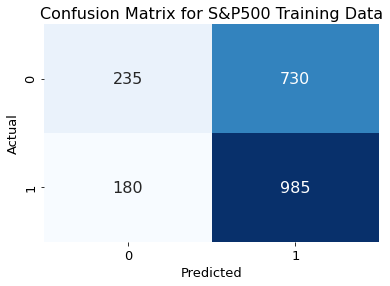

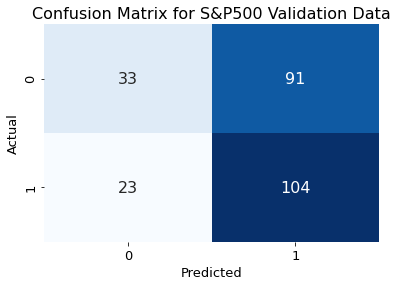

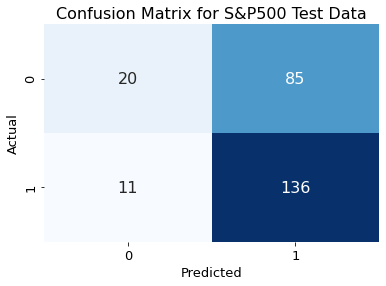

In [14]:
def confusion_matrix(model, x, y, dataset):
    y_pred = model.predict(x, batch_size=1)

    originals = []
    predictions = []

    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))
        
    df = pd.DataFrame()
    df['Actual'] = originals
    df['Predicted'] = predictions
    
    conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,annot_kws={"size": 16})
    plt.title(f"Confusion Matrix for S&P500 {dataset} Data", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Actual', fontsize = 13)
    plt.xlabel('Predicted', fontsize = 13)
    plt.savefig(f"Plots/Modelling/SP500 direction conf matrix {dataset}.png")
    plt.show()
    
confusion_matrix(model, x_train, y_train, "Training")
confusion_matrix(model, x_val, y_val, "Validation")
confusion_matrix(model, x_test, y_test, "Test")

In [54]:
def plot_acc_time(dates, accuracies):
    x = list(range(0, len(accuracies) - 1))
    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig1.add_trace(go.Scatter(x=dates, y=accuracies, mode="lines", name="Accuracy"), row=1, col=1)
    fig1.update_layout(
        title = "Acc", 
        xaxis1 = dict(title_text = "Date"),
        yaxis1 = dict(title_text = "Accuracy (%)"),
    )
#     fig1.write_image()
    fig1.show()

x = np.concatenate((x_train, x_val, x_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)
evaluate(model, x, y, "Full")

y_pred = model.predict(x, batch_size=1)

accuracies = []
reals = []
preds = []
full_preds = []
full_reals = []
for i in range(len(y)):
    reals.append(y[i][0])
    preds.append(int(round(y_pred[i][0][0])))
    
    full_reals.append(y[i][0])
    full_preds.append(int(round(y_pred[i][0][0])))
    if len(reals) > 250:
        accuracies.append(accuracy(reals, preds))
        reals.pop(0)
        preds.pop(0)
print(mean(accuracies))
dates = df.iloc[250:]['Date']
plot_acc_time(dates, accuracies)

df_temp = pd.DataFrame()
df_temp['Date'] = dates
df_temp['Acc'] = accuracies
df_temp.to_csv("Models/Models Output/SP500_direction_accuracies.csv")

df_temp = pd.DataFrame()
df_temp['Date'] = df['Date']
df_temp['SP500_relative_change_perc_1'] = df['SP500_relative_change_perc_1']
df_temp['pred'] = full_preds
df_temp['label'] = full_reals
df_temp.to_csv("Models/Models Output/SP500_direction_predictions.csv")
    

	AUC: 0.5600687011615874
	Accuracy: 0.5746296999620205
	Precision: 0.5748474894415767
	Recall = Sensitivity: 0.8512856150104239
	Specificity: 0.24120603015075376
	F1-score: 0.6862745098039216
0.5715752182206968


In [ ]:
def retrieve_candles(filename, val_year, test_year):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.columns = ["Date", "Close", "Open", "High", "Low", "Vol.", "Change%"]
    df = df.sort_values('Date', ascending=True)
    
    candles_val = df[df['Date'].dt.year == val_year]
    candles_train = df[df['Date'].dt.year < val_year]
    candles_train = candles_train[candles_train['Date'] > datetime(2009,7,10)]
    
    candles_train = candles_train.replace(',','', regex=True)
    candles_val = candles_val.replace(',','', regex=True)

    return candles_train, candles_val

def plot_predictions_candles(x, y, df, dataset):
    # PREDICTIONS LIJKEN NOG NIET GOED UITGELIJND MET CANDLES???
    originals = []
    predictions = []
    y_pred = model.predict(x)
    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))

    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name="Price"))
    standard_factor = 0.5 * mean([float(df.iloc[0].tolist()[3]), float(df.iloc[0].tolist()[4])])
    
    green_legend = False
    orange_legend = False
    red_legend = False
    
    for i, row in enumerate(df.iterrows()):
        pred_date = row[1][0].to_pydatetime()
        pred_high = float(row[1][3])
        pred_low = float(row[1][4])
#         real_label = row[1][7]
#         pred_label = row[1][8]
        real_label = originals[i]
        pred_label = predictions[i]
        
        start_shape = pred_date - timedelta(days=0.1)
        end_shape = pred_date + timedelta(days=0.1)
    
        
        if pred_label == 1:
            extreme = pred_high + 0.1 * standard_factor
            standard = pred_high + 0.05 * standard_factor
#         elif pred_label == 2:
#             extreme = pred_high + 0.2 * standard_factor
#             standard = pred_high + 0.05 * standard_factor
        elif pred_label == 0:
            extreme = pred_low - 0.1 * standard_factor
            standard = pred_low -  0.05 * standard_factor
#         elif pred_label == -2:
#             extreme = pred_low - 0.2 * standard_factor
#             standard = pred_low - 0.05 * standard_factor
            
        if real_label == pred_label:
            color = "green"
#         elif np.sign(real_label) == np.sign(pred_label):
#             color = "orange"
        else:
            color = "red"
        
        if real_label == pred_label and not green_legend:
            green_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction", mode="lines", line=dict(color=color)))
        
#         elif np.sign(real_label) == np.sign(pred_label) and not orange_legend:
#             orange_legend = True
#             fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
#                                  y=[standard,extreme,standard,standard], 
#                                  fill="toself", name="Correct Direction / Inorrect Magnitude", mode="lines", line=dict(color=color)))
        elif real_label != pred_label and not red_legend:
            red_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Incorrect Direction", mode="lines", line=dict(color=color)))
        else:
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", showlegend=False, mode="lines", line=dict(color=color)))
    
    title = f"Visualization of {dataset} Predictions"
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    layout = dict(title=title, height=800, width=1500)
    fig.update_layout(layout)
#     config = dict({'scrollZoom': True})
#     fig.show(config=config)
    fig.show()

filename = "Dataset v3/Indices/S&P 500 Historical Data.csv"
candles_train, candles_val = retrieve_candles(filename, val_year, test_year) 
# plot_predictions_candles(x_train, y_train, candles_train, "Training")
plot_predictions_candles(x_val, y_val, candles_val, "Validation")